# Support Vector Machine (SVM)

Support Vector Machine (SVM) เป็น supervised machine learning algorithm ที่ใช้ในงานจำแนกหรือคาดการณ์ข้อมูล
หลักการทำงานของ SVM คือ การค้นหา decision boundary ที่สามารถแยกกลุ่มข้อมูลออกจากกันโดย maximize ระยะห่างจุดข้อมูลต่างกลุ่มที่อยู่ใกล้กันที่สุด (margin) ทั้งนี้ SVM จะทำงานร่วมกับ kernel ประเภทต่างๆ ที่สามารถแปลง feature space ได้  ทำให้ SVM สามารถจำแนกกลุ่มข้อมูลโดย decision boundary ทั้งที่เป็นเชิงเส้น (linear)และไม่เป็นเชิงเส้น (non-linear) ได้มีประสิทธิภาพ โดยปรับ hyperparameters ที่เกี่ยวข้องจำนวนไม่มาก  ทำให้การใช้ SVM เป็นเป็นที่นิยมในงานจำแนกหรือคาดการณ์ที่มีความซับซ้อน

SVM สามารถทำได้ทั้งการจำแนกหมวดหมู่ (classification) และ การทำนายค่า (regression) โดยในบทเรียนนี้ เราจะแสดงการทำงานของโมเดลกับโจทย์การจำแนกหมวดหมู่

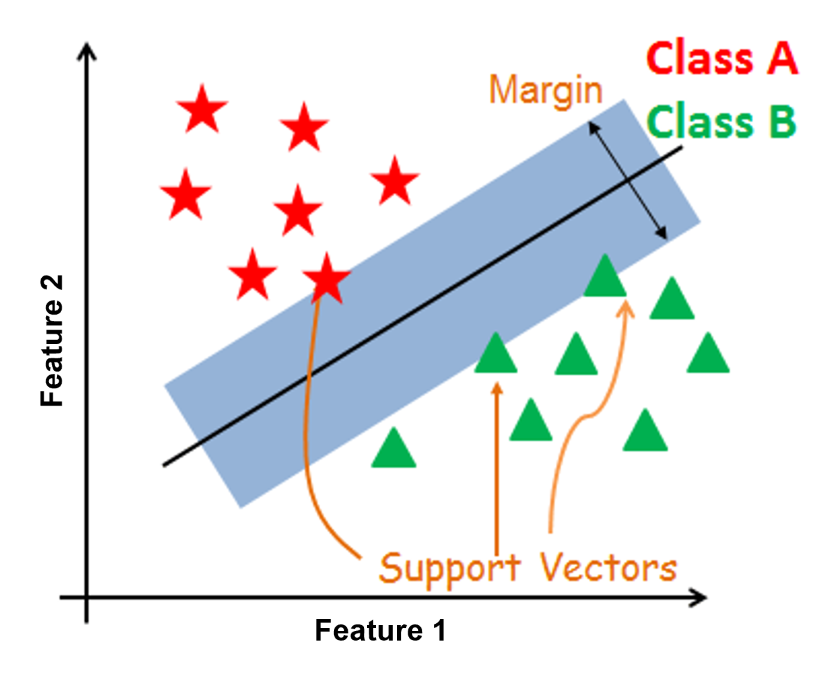 SVM algorithm, adapted from [ที่มา](https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python)

## Functional Margin, Separating Hyperplane และ Support Vectors

เพื่อศึกษาการทำงานของ SVM เราจะลองสร้างชุดข้อมูลที่ประกอบไปด้วย จำนวน $n=200$ จุด โดยประกอบด้วย 2 features และ $y$ มีค่า 0 หรือ 1 (2-class dataset for binary classification) โดยใช้ [Support Vector Classification](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) จากไลบรารี่ `scikit-learn`

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# ตั้งค่า random seed สำหรับการทำซ้ำ (reproducibility)
RANDOM_SEED = 2566

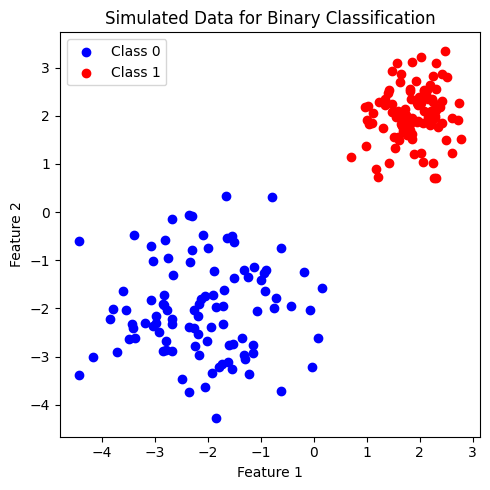

In [ ]:
def generate_multi_class_dataset(n_classes, mean_class, std_class,n_samples):
    # สร้างชุดข้อมูลแบบ multi-class
    # ตั้งค่า random seed สำหรับการทำซ้ำ (reproducibility)
    np.random.seed(RANDOM_SEED)

    # กำหนด จำนวน features
    n_features = 2

    #  สร้างข้อมูล x สำหรับแต่ละคลาส
    x_data = []
    for label in range(n_classes):
        _ = np.random.normal(mean_class[label], std_class[label], (n_samples, n_features))
        x_data.append(_)

    # สร้างข้อมูล y หรือ labels สำหรับแต่ละคลาส
    y_data = []
    y_data.append(np.zeros(n_samples))
    for label in range(1, n_classes):
        y_data.append(label*np.ones(n_samples))

    # รวมข้อมูล x และ y จากทุกคลาส
    x = np.vstack((x_data))
    y = np.hstack(y_data)

    return x, y

# ทดลองสร้างข้อมูลโดยการเรียกใช้ generate_multi_class_dataset
# กำหนด จำนวนคลาส
n_classes = 2

# กำหนดช่วงค่า Mean และ standard deviation สำหรับแต่ละคลาส
mean_class = [[-2,-2], [2,2]]
std_class  = [[1,1], [0.5,0.5]]

# กำหนดจำนวนข้อมูล สำหรับแต่ละคลาส
n_samples = 100

# ทำการสร้างชุดข้อมูล
x, y = generate_multi_class_dataset(n_classes, mean_class, std_class,n_samples)

# Plot ข้อมูล x, y ที่มีอยู่
plt.figure(figsize = (5,5))
plt.scatter(x[y==0, 0], x[y==0, 1], c='b', label='Class 0')
plt.scatter(x[y==1, 0], x[y==1, 1], c='r', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Simulated Data for Binary Classification')
plt.legend()
plt.tight_layout()
plt.show()

เราสามารถใช้ SVM ในการจำแนก class 0 และ class 1 อย่างง่ายโดยใช้ linear kernel ซึ่ง โมเดลจะสร้าง decision boundary ที่เป็นเส้นตรง เพื่อเป็นเงื่อนไขในการจำแนกคลาส

สังเกตว่า ชุดข้อมูลที่สร้างขึ้นมีการกระจายของข้อมูลในแต่ละคลาสแยกกันอย่างชัดเจน โดยเราสามารถขีดเส้นตรงเป็นจำนวนมากที่สามารถจำแนกคลาสได้ แล้ว SVM จะเลือกเส้นตรงเส้นไหน ด้วยเหตุผลอะไร

เส้นแบ่งคลาส ของ SVM มีชื่อเรียกเฉพาะว่า **separating hyperplane** ทั้งนี้ hyperplane หมายถึง พื้นที่ย่อยของหนึ่งมิติที่น้อยกว่าพื้นที่คุณลักษณะดั้งเดิม เช่น ใน 2D-space นั้น hyperplane คือ เส้น ส่วนใน 3D-space นั้น hyperplane คือระนาบ เป็นต้น

เพื่อให้การจำแนกคลาสเป็นไปอย่างแม่นยำและมีประสิทธิภาพสูง SVM ไม่เพียงแต่ค้นหา separating hyperplane ที่สามารถจำแนกคลาสของข้อมูลเท่านั้น แต่ยัง maximize ขนาด **functional margin** ซึ่งเป็นระยะห่างระหว่าง separating hyperplane กับจุดข้อมูลที่ใกล้เคียงที่สุดจากแต่ละคลาส ซึ่งมักจะเป็นจุดข้อมูลที่จำแนกได้ยากที่สุด จึงเป็นเงื่อนไขสำคัญสำหรับ SVM ที่จะตัดสินใจ จุดข้อมูลเหล่านี้มีชื่อเรียกเฉพาะว่า **support vectors** ดังตัวอย่างด้านล่าง

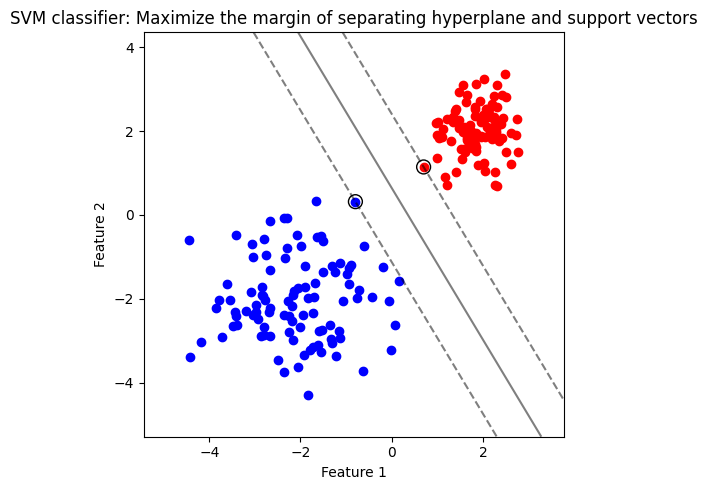

In [ ]:
# สร้างโมเดล
clf = SVC(kernel='linear', random_state=RANDOM_SEED)

# สอนโมเดลจากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้
clf.fit(x, y)

# Plot ข้อมูล x, y
plt.figure(figsize = (5,5))
plt.scatter(x[y==0, 0], x[y==0, 1], c='b', label='Class 0')
plt.scatter(x[y==1, 0], x[y==1, 1], c='r', label='Class 0')

# plot the decision function
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(clf,
                                       x,
                                       plot_method="contour",
                                       colors="k", levels=[-1, 0, 1],
                                       alpha=0.5, linestyles=["--", "-", "--"],ax=ax,
                                       )
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0],
           clf.support_vectors_[:, 1],
           s=100, linewidth=1,
           facecolors='none',
           edgecolors='k'
           )
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM classifier: Maximize the margin of separating hyperplane and support vectors')
plt.tight_layout()
plt.show()

รูปแสดง separating hyperplane (เส้นทึบ) ที่มี margin สูงสุด (ระยะห่างระหว่างเส้นประ) จาก support vectors (จุดข้อมูลในวงกลม) เมื่อใช้ linear kernel

## SVM เมื่อใช้ kernel ประเภทต่างๆ

Kernel ถูกนำมาใช้เพื่อเพิ่มความสามารถในการจำแนกชุดข้อมูลที่มีความซับซ้อนมากขึ้น โดยเพิ่มความสามารถในการสร้าง decision boundary ที่มีลักษณะ non-linear นอกจากนี้ บาง kernel  ยังสามารถแปลง features ของชุดข้อมูลไปสู่มิติที่สูงขึ้น โดย kernel อยู่ในรูปฟังก์ชันต่างๆ เช่น

- Linear kernel: ที่เราใช้ก่อนหน้านี้ เป็นการแยกกลุ่มข้อมูลด้วยเส้นตรงในมิติต้นฉบับ
- Polynomial kernel: ใช้สำหรับการแยกกลุ่มข้อมูลที่ด้วยเส้น polynomial ในมิติต้นฉบับ เมื่อใช้ polynomial kernel เราต้องกำหนด 'degree' ของ polynomial โดย เมื่อกำหนด degree=0  polynomial kernel จะทำงานเหมือนกับ linear kernel
- Radial Basis Function (RBF) Kernel: เป็น kernel ที่ถูกใช้งานมากและเป็นที่นิยม  เนื่องจากสามารถจำแนกกลุ่มข้อมูลที่มีลักษณะซับซ้อนได้ดี โดยแปลงข้อมูล features ไปสู่มิติที่สูงขึ้น  ทั้งนี้ RBF ยังเป็น default kernel ของ `scikit-learn` ในการทำ Support Vector Classification

เราสามารถเลือก kernel  ตามลักษณะของข้อมูลและงานที่ต้องการ
ดังตัวอย่างด้านล่าง

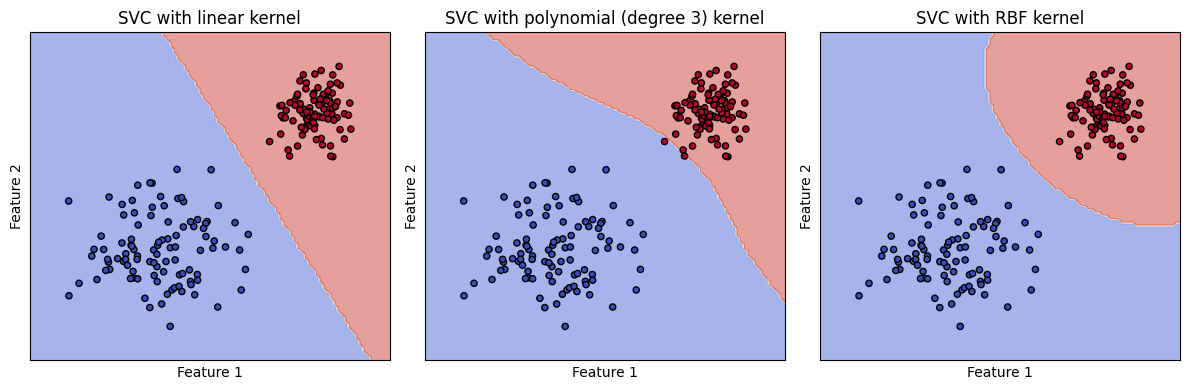

In [ ]:
# สร้างชุดโมเดล
models = (SVC(kernel='linear', random_state=RANDOM_SEED),
          SVC(kernel='poly', degree=3, random_state=RANDOM_SEED),
          SVC(kernel='rbf', random_state=RANDOM_SEED),
          )

# สอนโมเดลจากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้
models = (clf.fit(x, y) for clf in models)

# ตั้งชื่อ plot ที่สอดคล้องกับชุดข้อมูล
titles = ['SVC with linear kernel',
          'SVC with polynomial (degree 3) kernel',
          'SVC with RBF kernel',
          ]

# plot the decision boundaries
fig, axes = plt.subplots(1,3, figsize=(12, 4))
for clf, title, ax in zip(models, titles, axes.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(clf,
                                                  x,
                                                  response_method="predict",
                                                  cmap=plt.cm.coolwarm,
                                                  alpha=0.5,
                                                  ax=ax,
                                                  xlabel='Feature 1',
                                                  ylabel='Feature 2',
                                                  )
    ax.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
plt.tight_layout()
plt.show()

รูปแสดง separating hyperplane ของ SVM classifier ที่ใช้ linear kernel, polynomial (degree 3) kernel และ RBF kernel

จะสังเกตุได้ว่า โมเดลที่ใช้ linear kernel สร้าง separating hyperplane ที่มีลักษณะ linear ในขณะที่ polynomial (degree 3) kernel และ RBF kernel สร้าง separating hyperplane ที่มีลักษณะ non-linear

ต่อไปเราจะลองสร้างชุดข้อมูลที่มีความซับซ้อนมากขึ้น

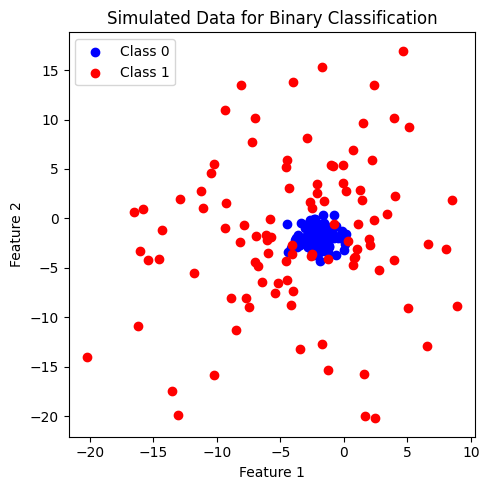

In [ ]:
# ทดลองสร้างข้อมูลโดยการเรียกใช้ generate_multi_class_dataset
# กำหนด จำนวนคลาส
n_classes = 2

# กำหนดช่วงค่า Mean และ standard deviation สำหรับแต่ละคลาส
mean_class = [[-2,-2], [-2,-2]]
std_class  = [[1,1], [7,7]]

# กำหนดจำนวนข้อมูล สำหรับแต่ละคลาส
n_samples = 100

# ทำการสร้างชุดข้อมูล
x, y = generate_multi_class_dataset(n_classes, mean_class, std_class,n_samples)

# Plot ข้อมูล x, y ที่มีอยู่
plt.figure(figsize = (5,5))
plt.scatter(x[y==0, 0], x[y==0, 1], c='b', label='Class 0')
plt.scatter(x[y==1, 0], x[y==1, 1], c='r', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Simulated Data for Binary Classification')
plt.legend()
plt.tight_layout()
plt.show()

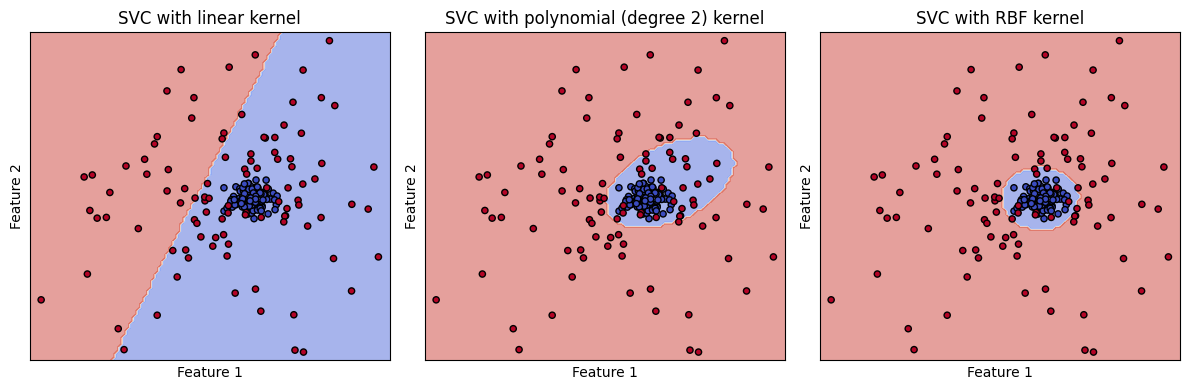

In [ ]:
# สร้างชุดโมเดล
models = (SVC(kernel='linear', random_state=RANDOM_SEED),
          SVC(kernel='poly', degree=2, random_state=RANDOM_SEED),
          SVC(kernel='rbf', random_state=RANDOM_SEED),
          )

# สอนโมเดลจากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้
models = (clf.fit(x, y) for clf in models)

# ตั้งชื่อ plot ที่สอดคล้องกับชุดข้อมูล
titles = ['SVC with linear kernel',
          'SVC with polynomial (degree 2) kernel',
          'SVC with RBF kernel',
          ]

# plot the decision boundaries
fig, axes = plt.subplots(1,3, figsize=(12, 4))
for clf, title, ax in zip(models, titles, axes.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(clf,
                                                  x,
                                                  response_method="predict",
                                                  cmap=plt.cm.coolwarm,
                                                  alpha=0.5,
                                                  ax=ax,
                                                  xlabel='Feature 1',
                                                  ylabel='Feature 2',
                                                  )
    ax.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
plt.tight_layout()
plt.show()

จะเห็นได้ว่า ข้อมูลชุดนี้ไม่เหมาะกับการใช้ linear kernel โดย พบว่า polynomial (degree 2) kernel และ RBF kernel สร้าง non-linear separating hyperplane ที่มีความเหมาะสมกับชุดข้อมูลมากกว่า

## SVM เมื่อใช้ร่วมกับ Regularization

เมื่อใช้งาน SVM ร่วมกับ kernel ที่สามารถแปลง features ของชุดข้อมูลเริ่มต้นให้มีมิติสูงขึ้น หรือสร้าง non-linear separating hyperplane ทำให้ SVM สามารถจำแนกกลุ่มข้อมูลที่มีความซับซ้อนและไม่เป็นเชิงเส้น (non-linear) ได้แม่นยำขึ้น แต่ในขณะเดียวกัน variance ของโมเดลที่สูงขึ้น ส่งผลให้สามารถเกิด overfitting ได้ง่าย  เพื่อลดปัญหานี้ เราสามารถใช้งาน SVM ร่วมกับ Regularization โดยในไลบรารี่ `scikit-learn` เราสามารถปรับค่า $\lambda$ ได้โดยผ่านทางพารามิเตอร์ $C$ โดย ค่า $C$ มีค่าเท่ากับ $1/\lambda$ (Inverse of Regularization Strength) โดยเป็นการใช้ L2 regularization

(more info [Scaling the regularization parameter for SVCs](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_scale_c.html))

max accuracy=0.7250 at C=10


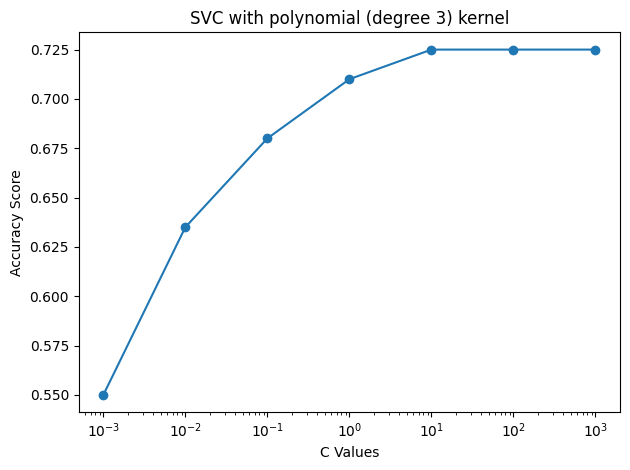

In [ ]:
# กำหนดช่วงค่า C
C_values = [0.001,0.01,0.1,1,10,100,1000]

# สร้างโมเดลด้วค่า C ต่างๆ ให้โมเดลเรียนรู้จากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้ แล้วทดสอบโมเดลด้วย accuracy score
accuracy = []
for C_val in C_values:
    clf = SVC(kernel='poly', degree=3, random_state=RANDOM_SEED, C=C_val)
    clf.fit(x, y)

    # ทำนายค่า y โดยใช้โมเดล
    prediction = clf.predict(x)

    # คำนวณ accuracy score
    accuracy.append(accuracy_score(y, prediction))

# แสดงผล
print('max accuracy={:.4f} at C={}'.format(np.max(accuracy), C_values[np.argmax(accuracy)]))
plt.plot(C_values, accuracy, marker='o')
plt.xscale('log')
plt.xlabel('C Values')
plt.ylabel('Accuracy Score')
plt.title('SVC with polynomial (degree 3) kernel')
plt.tight_layout()
plt.show()

ตัวอย่างแสดงให้เห็นว่า เราสามารถเพิ่ม accuracy ของโมเดลได้ด้วยการปรับค่า $C$ ที่เหมาะสม จะเห็นว่า L2 regulariztion ให้ค่า accuracy ค่อนข้างคงที่เมื่อ $C\ge10$ โดยมีค่า accuracy สูงสุดที่ $C=10$

## SVC pipeline

### Generate 3-class dataset

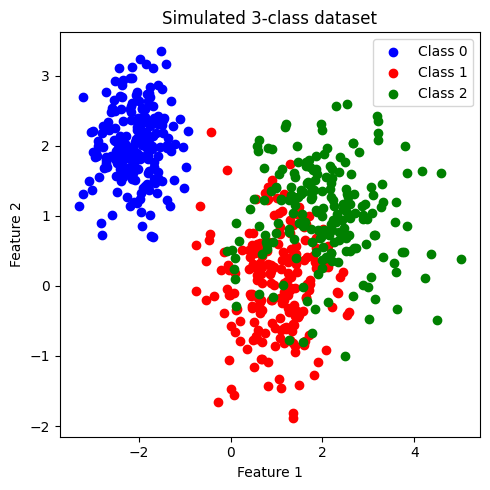

In [ ]:
# สร้างข้อมูลโดยการเรียกใช้ generate_multi_class_dataset
# กำหนด จำนวนคลาส
n_classes = 3

# กำหนดช่วงค่า Mean และ standard deviation สำหรับแต่ละคลาส
mean_class = [[-2,2], [1,0], [2,1]]#[[-2,2], [0,0], [2,2]]
std_class  = [[0.5,0.5], [0.75,0.75],[1,0.75]]#[[1,0.75], [1,0.75],[1,0.75]] #[[0.75,0.5], [0.5,1],[0.5,0.75]]

# กำหนดจำนวนข้อมูล สำหรับแต่ละคลาส
n_samples = 200

# ทำการสร้างชุดข้อมูล
x, y = generate_multi_class_dataset(n_classes, mean_class, std_class,n_samples)

# Plot ข้อมูล x, y ที่สร้างขึ้น
plt.figure(figsize = (5,5))
color_list = ['b','r','g']
for label in range(n_classes):
    plt.scatter(x[y==label, 0], x[y==label, 1], c=color_list[label], label='Class '+str(label))

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Simulated 3-class dataset')
plt.legend()
plt.tight_layout()
plt.show()


ข้อมูลที่สร้างขึ้นมีประกอบด้วย 2 features และ label แบ่งเป็น 3 กลุ่ม (class: 0, 1, 2) เราจะพัฒนาโมเดล SVM เพื่อจำแนกข้อมูลในแต่ละกลุ่ม

เมื่อสังเกตการกระจายตัวของข้อมูล พบว่า class 0 มีการกระจายข้อมูลแบ่งแยกออกมาอย่างเห็นได้ชัด ในขณะที่ class 1 และ class 2 จะกระจายตัวอยู่ร่วมกัน

### แบ่งข้อมูลเป็น training data และ test data

โดยใช้ [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) จากไลบรารี่ `scikit-learn`

ในตัวอย่างนี้เราจะใช้ default value ซึ่งจะ shuffle ข้อมูลก่อนแบ่งข้อมูล และ ไม่ stratify (ไม่กำกับสัดส่วนของ class ใน training data และ test data)

อย่างไรก็ดี ในกรณีที่ข้อมูลประกอบด้วย class ต่างๆ ที่มีสัดส่วนต่างกันอย่างมาก (imbalanced dataset) การทำ stratify มีความจำเป็นอย่างมากเพื่อคงสัดส่วนของแต่ละ class ใน training data และ test data

In [ ]:
# สร้าง training data และ test data โดยแบ่งจากชุดข้อมูล x,y
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    stratify=None, random_state=RANDOM_SEED)

print('Train set: จำนวนข้อมูล แบ่งกลุ่มตาม class label')
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

print('Test set: จำนวนข้อมูล แบ่งกลุ่มตาม class label')
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

Train set: จำนวนข้อมูล แบ่งกลุ่มตาม class label
[[  0. 169.]
 [  1. 155.]
 [  2. 156.]]
Test set: จำนวนข้อมูล แบ่งกลุ่มตาม class label
[[ 0. 31.]
 [ 1. 45.]
 [ 2. 44.]]


### ทำการ standardize ข้อมูลทั้งหมด
ใช้ mean และ standard deviation (SD) จาก training data ในการ standardize test set เพื่อป้องกัน information leak

In [ ]:
# สร้าง standardized scaler จาก features ใน training data
x_scaler = StandardScaler().fit(x_train)

# scale ค่า features ใน training data และ test data
x_train = x_scaler.transform(x_train)
x_test  = x_scaler.transform(x_test)

### เทรนโมเดล ด้วย base model (default hyperparameter)

Training Set: Classification report
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       169
         1.0       0.82      0.85      0.83       155
         2.0       0.85      0.81      0.83       156

    accuracy                           0.89       480
   macro avg       0.89      0.89      0.89       480
weighted avg       0.89      0.89      0.89       480


Test Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        31
         1.0       0.82      0.91      0.86        45
         2.0       0.90      0.80      0.84        44

    accuracy                           0.89       120
   macro avg       0.91      0.90      0.90       120
weighted avg       0.89      0.89      0.89       120



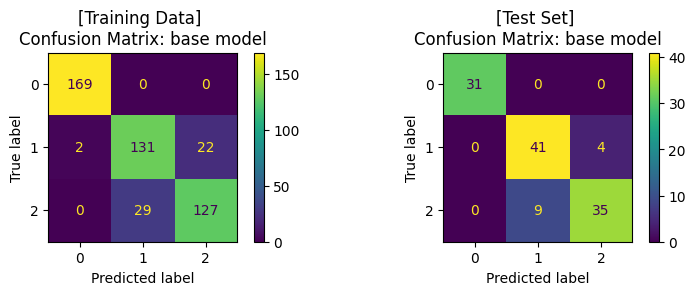

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# สร้างโมเดล
base_clf = SVC(random_state=RANDOM_SEED)

# สอนโมเดลด้วย training data
base_clf.fit(x_train,y_train)

# ให้โมเดลทำนาย training data
y_pred = base_clf.predict(x_train)

# แสดงผล classification ของโมเดลจาก training data
print('Training Set: Classification report')
print(classification_report(y_train, y_pred))

# คำนวนและแสดงผล confusion matrix ของ training data
cm = confusion_matrix(y_train, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax1)
ax1.set_title('[Training Data] \nConfusion Matrix: base model')

# ให้โมเดลทำนาย test data
y_pred = base_clf.predict(x_test)

# แสดงผล classification ของโมเดล
print('\nTest Set: Classification report')
print(classification_report(y_test, y_pred))

# คำนวนและแสดงผล confusion matrix ของ test set
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax2)
ax2.set_title('[Test Set] \nConfusion Matrix: base model')

plt.tight_layout()
plt.show()

### ปรับแต่งโมเดล (Hyperparameter Tuning) ด้วย [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) และ train โมเดล

โดยเราจะปรับแต่งโมเดล โดย tune 2 hyperparameters ที่สำคัญของ SVM ได้แก่
1. 'kernel'
2. 'C'

ในไลบรารี่ `scikit-learn` ยังมีวิธีการอื่นๆ ในการปรับแต่งโมเดล เช่น
- [CrossValScore](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score)
- [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)



Best hyperparameters: {'C': 10, 'kernel': 'rbf'}
Best cross-validation score: 0.89
Training Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       169
         1.0       0.82      0.90      0.86       155
         2.0       0.89      0.81      0.85       156

    accuracy                           0.91       480
   macro avg       0.91      0.90      0.90       480
weighted avg       0.91      0.91      0.91       480


Test Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        31
         1.0       0.83      0.96      0.89        45
         2.0       0.95      0.80      0.86        44

    accuracy                           0.91       120
   macro avg       0.92      0.92      0.92       120
weighted avg       0.92      0.91      0.91       120



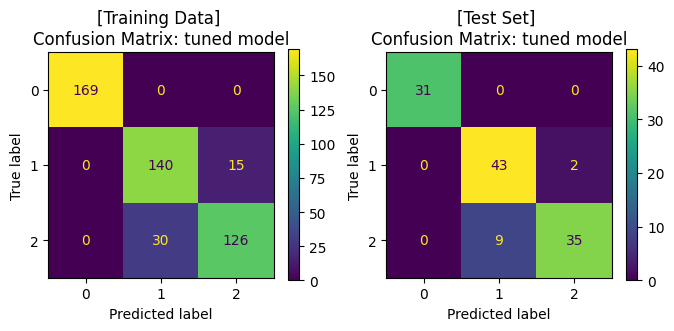

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# กำหนดช่วงค่า hyperparameters ในรูปแบบ dictionary
clf_params = {'kernel': ['rbf','linear'],
              'C': [0.01, 0.1, 1, 10, 100, 1000]
              }

# แบ่งข้อมูล training data ด้วย 5-fold cross-validation เพื่อ tune hyperparameter
cv_splitter = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# ใช้ GridSearchCV เพื่อสอนโมเดลจากชุดค่า hyperparameters จาก clf_params
# และคำนวณค่า accuracy ของแต่ละโมเดล เพื่อเลือกชุด hyperparameters ที่ดีที่สุด
# โดยใช้เทคนิค cross-validation ในการแบ่งกลุ่ม validation data จาก training data
tuned_clf = GridSearchCV(estimator=base_clf, param_grid=clf_params,
                             scoring=['accuracy'], refit='accuracy', cv=cv_splitter)

# fit โมเดลด้วย training data และ ให้โมเดลทำนายค่า y จาก training data
tuned_clf.fit(x_train, y_train)
y_pred = tuned_clf.predict(x_train)

# แสดงผล hyperparameters ที่ดีที่สุด และ cross-validation score
print('Best hyperparameters: {}'.format(tuned_clf.best_params_))
print("Best cross-validation score: {:.2f}".format(tuned_clf.best_score_))

# แสดงผล classification ของโมเดลจาก training data
print('Training Set: Classification report')
print(classification_report(y_train, y_pred))

# คำนวนและแสดงผล confusion matrix ของโมเดลจาก training data
cm = confusion_matrix(y_train, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax1)
ax1.set_title('[Training Data] \nConfusion Matrix: tuned model')

# ให้โมเดลทำนายค่า y จาก test data
y_pred = tuned_clf.predict(x_test)

# แสดงผล classification ของโมเดล จาก test data
print('\nTest Set: Classification report')
print(classification_report(y_test, y_pred))
# คำนวนและแสดงผล confusion matrix จาก test data
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax2)
ax2.set_title('[Test Set] \nConfusion Matrix: tuned model')

plt.show()

จะสังเกตได้ว่า เมื่อมีการปรับจูน hyperparameters ของโมเดลให้มีความเหมาะสมแล้ว เราได้โมเดลที่เรียนรู้จากข้อมูลชุดเดิม แล้วสามารถทำนายได้ค่า accuracy ที่สูงขึ้น โดยเมื่อพิจารณา Confusion Matrix จะพบว่า โมเดลสามารถจำแนกข้อมูล class 1 และ class 2 ได้ดีขึ้น